# SETUP

In [6]:
import os

# Set the environment variable 'TF_CPP_MIN_LOG_LEVEL' to '3'.
# This suppresses most of TensorFlow's logging output, keeping the console clean.
# Levels: 0 = all logs, 1 = no info, 2 = no warnings, 3 = no errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set the environment variable 'TF_ENABLE_ONEDNN_OPTS' to '0'.
# This disables oneDNN/MKL optimizations in TensorFlow
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import math
import numpy as np
import matplotlib.pyplot as plt

import json

import keras_tuner as kt
import tensorflow as tf

from geexhp import datavis as dvis
# dvis.configure_matplotlib()

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# DATA PREPROCESSING PIPELINE

In [7]:
# def compute_normalization_stats(train_tfrecord_path):
#     # Initialize accumulators
#     stats = {
#         'inputs': {'UV': {'sum': 0., 'sq_sum': 0., 'count': 0},
#                     'Vis': {'sum': 0., 'sq_sum': 0., 'count': 0},
#                     'NIR': {'sum': 0., 'sq_sum': 0., 'count': 0}},
#         'outputs': {key: {'sum': 0., 'sq_sum': 0., 'count': 0} 
#                    for key in ['OBJECT-RADIUS-REL-EARTH', 'OBJECT-GRAVITY', 
#                                 'ATMOSPHERE-TEMPERATURE', 'ATMOSPHERE-PRESSURE',
#                                 'log_C2H6', 'log_CH4', 'log_CO', 'log_CO2', 'log_H2O', 'log_N2', 'log_N2O', 'log_O2', 'log_O3']}
#     }

#     # Parse function for raw data
#     def parse_fn(example):
#         features = {
#             # Inputs
#             # 'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
#             # 'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
#             # 'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),

#             'ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
#             'ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
#             'ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),

#             # Outputs
#             'OBJECT-RADIUS-REL-EARTH': tf.io.FixedLenFeature([], tf.float32),
#             'OBJECT-GRAVITY': tf.io.FixedLenFeature([], tf.float32),
#             'ATMOSPHERE-TEMPERATURE': tf.io.FixedLenFeature([], tf.float32),
#             'ATMOSPHERE-PRESSURE': tf.io.FixedLenFeature([], tf.float32),
#             'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
#             'log_CH4': tf.io.FixedLenFeature([], tf.float32),
#             'log_CO': tf.io.FixedLenFeature([], tf.float32),
#             'log_CO2': tf.io.FixedLenFeature([], tf.float32),
#             'log_H2O': tf.io.FixedLenFeature([], tf.float32),
#             'log_N2': tf.io.FixedLenFeature([], tf.float32),
#             'log_N2O': tf.io.FixedLenFeature([], tf.float32),
#             'log_O2': tf.io.FixedLenFeature([], tf.float32),
#             'log_O3': tf.io.FixedLenFeature([], tf.float32)
#         }
#         return tf.io.parse_single_example(example, features)

#     # Process dataset
#     dataset = tf.data.TFRecordDataset(train_tfrecord_path)
#     dataset = dataset.map(parse_fn)
    
#     for batch in dataset.batch(1000):  # Process in chunks
#         # Inputs
#         for region in ['UV', 'Vis', 'NIR']:
#             key = f'ALBEDO_B-{region}'
#             data = tf.sparse.to_dense(batch[key]).numpy()
#             stats['inputs'][region]['sum'] += np.sum(data)
#             stats['inputs'][region]['sq_sum'] += np.sum(data**2)
#             stats['inputs'][region]['count'] += data.size
            
#         # Outputs 
#         for key in stats['outputs']:
#             data = batch[key].numpy()
#             stats['outputs'][key]['sum'] += np.sum(data)
#             stats['outputs'][key]['sq_sum'] += np.sum(data**2)
#             stats['outputs'][key]['count'] += data.size

#     # Calculate final stats
#     final_stats = {}
    
#     # Input stats
#     final_stats['inputs'] = {}
#     for region in ['UV', 'Vis', 'NIR']:
#         mean = stats['inputs'][region]['sum'] / stats['inputs'][region]['count']
#         std = np.sqrt((stats['inputs'][region]['sq_sum'] / stats['inputs'][region]['count']) - mean**2)
#         final_stats['inputs'][region] = {'mean': float(mean), 'std': float(std)}
    
#     # Output stats
#     final_stats['outputs'] = {}
#     for key in stats['outputs']:
#         mean = stats['outputs'][key]['sum'] / stats['outputs'][key]['count']
#         std = np.sqrt((stats['outputs'][key]['sq_sum'] / stats['outputs'][key]['count']) - mean**2)
#         final_stats['outputs'][key] = {'mean': float(mean), 'std': float(std)}
    
#     # Save to JSON
#     with open('normalization_stats.json', 'w') as f:
#         json.dump(final_stats, f)
        
#     return final_stats

# # Run this once on your training data
# # stats = compute_normalization_stats("../data/train.tfrecord")

# DATA LOADING PIPELINE IMPLEMENTATION

In [8]:
# Load statistics from Phase 1
with open('normalization_stats.json') as f:
    stats = json.load(f)

# Create lookup dictionaries for TF operations
input_stats = {
    'UV': (stats['inputs']['UV']['mean'], stats['inputs']['UV']['std']),
    'Vis': (stats['inputs']['Vis']['mean'], stats['inputs']['Vis']['std']),
    'NIR': (stats['inputs']['NIR']['mean'], stats['inputs']['NIR']['std'])
}

output_stats = {
    key: (stats['outputs'][key]['mean'], stats['outputs'][key]['std'])
    for key in stats['outputs']
}

In [9]:
def parse_example(example_proto, input_stats, output_stats):
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
        'log_CH4': tf.io.FixedLenFeature([], tf.float32),
        'log_CO': tf.io.FixedLenFeature([], tf.float32),
        'log_CO2': tf.io.FixedLenFeature([], tf.float32),
        'log_H2O': tf.io.FixedLenFeature([], tf.float32),
        'log_N2': tf.io.FixedLenFeature([], tf.float32),
        'log_N2O': tf.io.FixedLenFeature([], tf.float32),
        'log_O2': tf.io.FixedLenFeature([], tf.float32),
        'log_O3': tf.io.FixedLenFeature([], tf.float32)
    }

    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # ----------------------
    # Input Normalization
    # ----------------------
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        # Get raw spectrum
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)
        
        # Normalize using dataset statistics
        mean = input_stats[region][0]
        std = input_stats[region][1]
        normalized = (spectrum - mean) / std
        
        # Reshape to appropriate dimensions
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])
            
        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    # ----------------------
    # Output Processing
    # ----------------------
    processed_outputs = {}
    
    radius = parsed['OBJECT-RADIUS-REL-EARTH']
    processed_outputs['OBJECT-RADIUS-REL-EARTH'] = (radius - output_stats['OBJECT-RADIUS-REL-EARTH'][0]) / output_stats['OBJECT-RADIUS-REL-EARTH'][1]
    
    gravity = parsed['OBJECT-GRAVITY']
    processed_outputs['OBJECT-GRAVITY'] = (gravity - output_stats['OBJECT-GRAVITY'][0]) / output_stats['OBJECT-GRAVITY'][1]
    
    temperature = parsed['ATMOSPHERE-TEMPERATURE']
    processed_outputs['ATMOSPHERE-TEMPERATURE'] = (temperature - output_stats['ATMOSPHERE-TEMPERATURE'][0]) / output_stats['ATMOSPHERE-TEMPERATURE'][1]
    
    pressure = parsed['ATMOSPHERE-PRESSURE']
    processed_outputs['ATMOSPHERE-PRESSURE'] = (pressure - output_stats['ATMOSPHERE-PRESSURE'][0]) / output_stats['ATMOSPHERE-PRESSURE'][1]
    
    # Process chemical abundances (already in log scale)
    for chem in ['log_C2H6', 'log_CH4', 'log_CO', 'log_CO2', 'log_H2O', 'log_N2', 'log_N2O', 'log_O2', 'log_O3']:
        chem_value = parsed[chem]
        processed_outputs[f'{chem}'] = (chem_value - output_stats[f'{chem}'][0]) /  output_stats[f'{chem}'][1]

    return normalized_inputs, processed_outputs

In [10]:
def read_tfrecord(
    file_path, 
    input_stats, 
    output_stats, 
    batch_size=256, 
    shuffle_buffer=None,  # or shuffle=False
    repeat=False
):
    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if repeat:
        dataset = dataset.repeat(None)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    # parsed_dataset = tf.data.Dataset.range(1).interleave(
    #     lambda _: parsed_dataset, 
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    return parsed_dataset

In [11]:
train_ds = read_tfrecord("../data2/train.tfrecord", input_stats, output_stats, shuffle_buffer=10000, repeat=True)
val_ds = read_tfrecord("../data2/val.tfrecord", input_stats, output_stats)
test_ds = read_tfrecord("../data2/test.tfrecord", input_stats, output_stats)

# Inspect a batch
sample_inputs, sample_outputs = next(iter(train_ds.take(1)))

print("\nInput Shapes:")
for k,v in sample_inputs.items():
    print(f"{k}: {v.shape}")  # Should be (batch_size, channels, 1)

print("\nOutput Ranges (standardized):")
for k,v in sample_outputs.items():
    print(f"{k}: {tf.reduce_mean(v):.3f} ± {tf.math.reduce_std(v):.6f}")


Input Shapes:
NOISY_ALBEDO_B-UV: (256, 8, 1)
NOISY_ALBEDO_B-Vis: (256, 94, 1)
NOISY_ALBEDO_B-NIR: (256, 49, 1)

Output Ranges (standardized):
OBJECT-RADIUS-REL-EARTH: 0.067 ± 0.994104
OBJECT-GRAVITY: 0.067 ± 0.990485
ATMOSPHERE-TEMPERATURE: 0.072 ± 1.058761
ATMOSPHERE-PRESSURE: 0.067 ± 1.002811
log_C2H6: 0.694 ± 0.000000
log_CH4: -1.270 ± 0.439305
log_CO: -0.866 ± 0.541872
log_CO2: -0.959 ± 0.722858
log_H2O: -0.286 ± 0.757217
log_N2: -0.661 ± 1.460035
log_N2O: -0.459 ± 0.213037
log_O2: 0.295 ± 0.499784
log_O3: -0.391 ± 0.262449


In [7]:
# def count_samples(dataset: tf.data.Dataset):
#     """
#     Count the total number of samples in a dataset by iterating once.
#     If the dataset is batched, unbatch it first. 
#     """
#     count = 0
#     for _ in dataset.unbatch():
#         count += 1
#     return count

# TRAIN_SAMPLES = count_samples(train_ds) # 779887
# print("Train samples:", TRAIN_SAMPLES)      

# VAL_SAMPLES = count_samples(val_ds)
# print("Validation samples:", VAL_SAMPLES)  # 66676

In [53]:
def plot_spectrum(ds, sample_number):
    for batch in ds.take(1):
        pass

    x1 = batch[0]['NOISY_ALBEDO_B-UV'][sample_number]
    x2 = batch[0]['NOISY_ALBEDO_B-Vis'][sample_number]
    x3 = batch[0]['NOISY_ALBEDO_B-NIR'][sample_number]

    bins1 = np.linspace(1, len(x1), len(x1))
    bins2 = np.linspace(len(x1), len(x1)+len(x2), len(x2))
    bins3 = np.linspace(len(x1)+len(x2), len(x1)+len(x2)+len(x3), len(x3))

    plt.plot(bins1, x1, label='UV')
    plt.plot(bins2, x2, label='Vis')
    plt.plot(bins3, x3, label='NIR')
    plt.legend()
    plt.show()

    for output in batch[1].keys():
        print(f'{output}: \t {batch[1][output][sample_number]}')

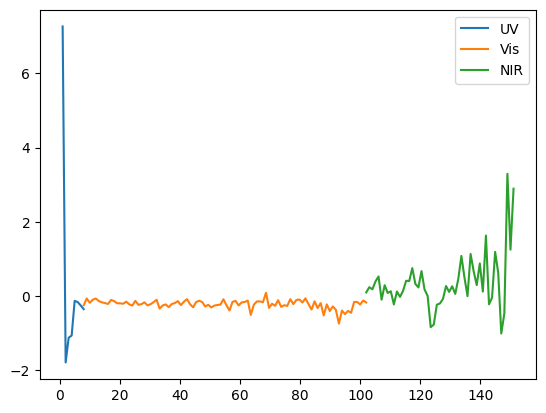

OBJECT-RADIUS-REL-EARTH: 	 -0.680770993232727
OBJECT-GRAVITY: 	 -0.7673196792602539
ATMOSPHERE-TEMPERATURE: 	 0.398089736700058
ATMOSPHERE-PRESSURE: 	 -0.7674235701560974
log_C2H6: 	 0.6936268210411072
log_CH4: 	 -1.9848887920379639
log_CO: 	 -1.1758174896240234
log_CO2: 	 -1.3823415040969849
log_H2O: 	 -0.37430283427238464
log_N2: 	 0.48613470792770386
log_N2O: 	 -0.6971712708473206
log_O2: 	 -0.6116629838943481
log_O3: 	 -0.5559867024421692


In [60]:
plot_spectrum(train_ds, 0)

In [76]:
# The number of training samples in the dataset.
TRAIN_SAMPLES = 779887

# THe number of validation samples in the dataset.
VAL_SAMPLES = 66676

# Define the batch size to use for training, validation, and testing.
# A batch size of 256 means that the model will process 256 samples at a time.
BATCH_SIZE = 256

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

# MODEL 1 ARCHITECTURE DESIGN

In [9]:
def build_model():
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

    input_uv = tf.keras.layers.Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    x = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])

    x = tf.keras.layers.Conv1D(64, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(64, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(48, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(16, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv1D(8, 5, activation='swish')(x)
    x = tf.keras.layers.Conv1D(8, 5, activation='swish')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(
            units=1,
            activation='linear',
            kernel_regularizer=tf.keras.regularizers.l1(1e-5),
            name=output_name
        )(x)
        outputs[output_name] = output

    losses = {output_name: 'mae' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    learning_rate = 1e-4
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-5

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="test_4")
    model.compile(optimizer=opt, loss=losses)

    return model

In [10]:
model = build_model()
model.summary()

Model: "test_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_B-UV   │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-Vis  │ (None, 94, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-NIR  │ (None, 49, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 151, 1)    │          0 │ NOISY_ALBEDO_B-U… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_B-V… │
│                     │                   │            │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 147, 64)   │        384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 143, 64)   │     20,544 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 71, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 71, 64)    │        256 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 67, 48)    │     15,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 63, 48)    │     11,568 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 31, 48)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 48)    │        192 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 27, 16)    │      3,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 23, 16)    │      1,296 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 11, 16)    │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 16)    │         64 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 7, 8)      │        648 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 8)      │        328 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 8)      │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 66,493 (259.74 KB)

 Trainable params: 66,221 (258.68 KB)

 Non-trainable params: 272 (1.06 KB)

## TRAINING STRATEGY & OPTIMIZATION

In [11]:
EPOCHS = 100

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         min_delta=0.001,
#         restore_best_weights=True
#     ),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-7
#     ),

# ]


# Final training call
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    #callbacks=callbacks,
)

Epoch 1/100


I0000 00:00:1738014540.105952 3390682 service.cc:148] XLA service 0x7c588c00a990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738014540.106004 3390682 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1738014541.102962 3390682 cuda_dnn.cc:529] Loaded cuDNN version 90600


  15/3047 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - ATMOSPHERE-PRESSURE_loss: 0.8922 - ATMOSPHERE-TEMPERATURE_loss: 0.9980 - OBJECT-GRAVITY_loss: 0.9135 - OBJECT-RADIUS-REL-EARTH_loss: 0.9409 - log_C2H6_loss: 1.0901 - log_CH4_loss: 1.2371 - log_CO2_loss: 1.1213 - log_CO_loss: 0.8577 - log_H2O_loss: 0.7535 - log_N2O_loss: 0.5127 - log_N2_loss: 1.0488 - log_O2_loss: 0.5276 - log_O3_loss: 0.3866 - loss: 11.4231

I0000 00:00:1738014545.781369 3390682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3047/3047 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - ATMOSPHERE-PRESSURE_loss: 0.8403 - ATMOSPHERE-TEMPERATURE_loss: 0.8381 - OBJECT-GRAVITY_loss: 0.8515 - OBJECT-RADIUS-REL-EARTH_loss: 0.8475 - log_C2H6_loss: 0.4486 - log_CH4_loss: 0.7155 - log_CO2_loss: 0.8032 - log_CO_loss: 0.6081 - log_H2O_loss: 0.6904 - log_N2O_loss: 0.3908 - log_N2_loss: 0.7921 - log_O2_loss: 0.5734 - log_O3_loss: 0.3771 - loss: 8.9116 - val_ATMOSPHERE-PRESSURE_loss: 0.7375 - val_ATMOSPHERE-TEMPERATURE_loss: 0.7673 - val_OBJECT-GRAVITY_loss: 0.7329 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.7353 - val_log_C2H6_loss: 1.2022 - val_log_CH4_loss: 0.8100 - val_log_CO2_loss: 0.8337 - val_log_CO_loss: 1.0061 - val_log_H2O_loss: 0.7862 - val_log_N2O_loss: 1.0944 - val_log_N2_loss: 0.5258 - val_log_O2_loss: 0.7523 - val_log_O3_loss: 1.0824 - val_loss: 11.1834
Epoch 2/100
  10/3047 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - ATMOSPHERE-PRESSURE_loss: 0.7998 - ATMOSPHERE-TEMPERATURE_loss: 0.7900 - OBJECT-GRAVITY_loss: 0.7956 - OBJECT-RADIUS-

/home/cleber/Documentos/Sarah/Git/geexhp/myenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3047/3047 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - ATMOSPHERE-PRESSURE_loss: 0.6610 - ATMOSPHERE-TEMPERATURE_loss: 0.7709 - OBJECT-GRAVITY_loss: 0.6665 - OBJECT-RADIUS-REL-EARTH_loss: 0.6598 - log_C2H6_loss: 0.3771 - log_CH4_loss: 0.6877 - log_CO2_loss: 0.7541 - log_CO_loss: 0.6144 - log_H2O_loss: 0.6300 - log_N2O_loss: 0.3750 - log_N2_loss: 0.7508 - log_O2_loss: 0.5199 - log_O3_loss: 0.3645 - loss: 7.9349 - val_ATMOSPHERE-PRESSURE_loss: 0.6986 - val_ATMOSPHERE-TEMPERATURE_loss: 0.7587 - val_OBJECT-GRAVITY_loss: 0.7051 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.7035 - val_log_C2H6_loss: 1.1753 - val_log_CH4_loss: 0.7777 - val_log_CO2_loss: 0.8161 - val_log_CO_loss: 1.0206 - val_log_H2O_loss: 0.7281 - val_log_N2O_loss: 1.1339 - val_log_N2_loss: 0.5144 - val_log_O2_loss: 0.7487 - val_log_O3_loss: 1.1095 - val_loss: 10.9849
Epoch 3/100
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - ATMOSPHERE-PRESSURE_loss: 0.5790 - ATMOSPHERE-TEMPERATURE_loss: 0.7600 - OBJECT-GRAVITY_loss: 0.5797 - OBJECT-RADIUS-

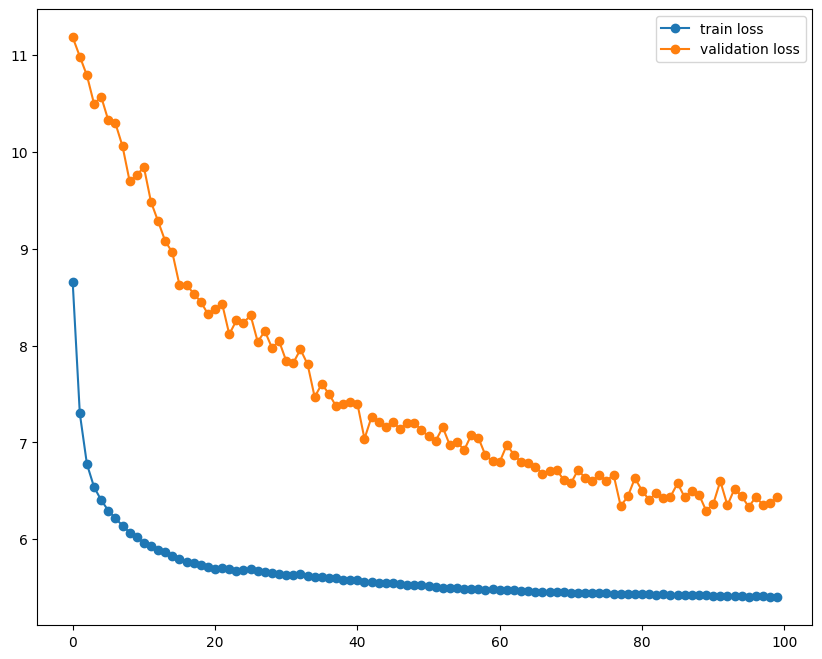

In [16]:
plt.figure(figsize=(10,8))
plt.plot(range(EPOCHS), history.history["loss"], marker="o", label="train loss")
plt.plot(range(EPOCHS), history.history["val_loss"], marker="o", label="validation loss")
plt.legend();

# Model 2

In [109]:
def conv_1D_block(input_tensor, num_filters, kernel_size=3, strides=1,
                    kernel_initializer='glorot_uniform', activation='swish'):
    
    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                   kernel_initializer=kernel_initializer,
                                   activation=activation)(input_tensor)

    z = tf.keras.layers.Conv1D(num_filters, kernel_size, strides=strides,
                                kernel_initializer=kernel_initializer,
                                activation=activation)(z)

    z = tf.keras.layers.MaxPooling1D(pool_size=2)(z)

    return z

In [110]:
def build_model_2():
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

    input_uv = tf.keras.layers.Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    # First convolutional branch of the network.
    concat_branch = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])
    concat_branch = conv_1D_block(input_tensor=concat_branch, num_filters=16)
    concat_branch = conv_1D_block(input_tensor=concat_branch, num_filters=8)
    concat_branch = tf.keras.layers.Flatten()(concat_branch)

    # UV convolutional branch.
    UV = conv_1D_block(input_tensor=input_uv, num_filters=8)
    UV = tf.keras.layers.Flatten()(UV)

    # Vis convolutional branch.
    VIS = conv_1D_block(input_tensor=input_vis, num_filters=32)
    VIS = conv_1D_block(input_tensor=VIS, num_filters=16)
    VIS = conv_1D_block(input_tensor=VIS, num_filters=8)
    VIS = tf.keras.layers.Flatten()(VIS)

    # NIR convolutional branch.
    NIR = conv_1D_block(input_tensor=input_nir, num_filters=16)
    NIR = conv_1D_block(input_tensor=NIR, num_filters=8)
    NIR = tf.keras.layers.Flatten()(NIR)
    
    combined_braches = tf.keras.layers.Concatenate()([concat_branch,
                                                       UV,
                                                       VIS,
                                                       NIR])

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(combined_braches)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Output Layers
    outputs = {}
    for output_name in outputs_list:
        output = tf.keras.layers.Dense(
            units=1,
            activation='linear',
            kernel_regularizer=tf.keras.regularizers.l1(1e-5),
            name=output_name
        )(x)
        outputs[output_name] = output

    losses = {output_name: 'mae' for output_name in outputs_list}

    inpts = [input_uv, input_vis, input_nir]

    learning_rate = 1e-4
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-5

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    model = tf.keras.Model(inputs=inpts, outputs=outputs, name="test_5")
    model.compile(optimizer=opt, loss=losses)

    return model

In [111]:
model2 = build_model_2()

EPOCHS2 = 10

# Final training call
history2 = model2.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    #callbacks=callbacks,
)

Epoch 1/10
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - ATMOSPHERE-PRESSURE_loss: 0.8441 - ATMOSPHERE-TEMPERATURE_loss: 0.7849 - OBJECT-GRAVITY_loss: 0.8448 - OBJECT-RADIUS-REL-EARTH_loss: 0.8403 - log_C2H6_loss: 0.3609 - log_CH4_loss: 0.6728 - log_CO2_loss: 0.7277 - log_CO_loss: 0.5771 - log_H2O_loss: 0.6794 - log_N2O_loss: 0.3358 - log_N2_loss: 0.7847 - log_O2_loss: 0.5404 - log_O3_loss: 0.3598 - loss: 8.6253 - val_ATMOSPHERE-PRESSURE_loss: 0.6340 - val_ATMOSPHERE-TEMPERATURE_loss: 0.7591 - val_OBJECT-GRAVITY_loss: 0.6506 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.6231 - val_log_C2H6_loss: 0.9442 - val_log_CH4_loss: 0.6436 - val_log_CO2_loss: 0.7100 - val_log_CO_loss: 0.8405 - val_log_H2O_loss: 0.6856 - val_log_N2O_loss: 0.9108 - val_log_N2_loss: 0.5113 - val_log_O2_loss: 0.7339 - val_log_O3_loss: 0.8849 - val_loss: 9.7257
Epoch 2/10
  13/3047 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - ATMOSPHERE-PRESSURE_loss: 0.7020 - ATMOSPHERE-TEMPERATURE_loss: 0.7528 - OBJECT-GRAVITY_loss: 0.7292 - OBJECT-

/home/cleber/Documentos/Sarah/Git/geexhp/myenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3047/3047 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - ATMOSPHERE-PRESSURE_loss: 0.6272 - ATMOSPHERE-TEMPERATURE_loss: 0.7635 - OBJECT-GRAVITY_loss: 0.6233 - OBJECT-RADIUS-REL-EARTH_loss: 0.6194 - log_C2H6_loss: 0.2816 - log_CH4_loss: 0.5358 - log_CO2_loss: 0.6554 - log_CO_loss: 0.5369 - log_H2O_loss: 0.5946 - log_N2O_loss: 0.2999 - log_N2_loss: 0.7455 - log_O2_loss: 0.5032 - log_O3_loss: 0.3058 - loss: 7.2712 - val_ATMOSPHERE-PRESSURE_loss: 0.5205 - val_ATMOSPHERE-TEMPERATURE_loss: 0.7557 - val_OBJECT-GRAVITY_loss: 0.5117 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.5110 - val_log_C2H6_loss: 0.6658 - val_log_CH4_loss: 0.4991 - val_log_CO2_loss: 0.6256 - val_log_CO_loss: 0.6508 - val_log_H2O_loss: 0.6170 - val_log_N2O_loss: 0.6413 - val_log_N2_loss: 0.5031 - val_log_O2_loss: 0.6792 - val_log_O3_loss: 0.6454 - val_loss: 7.9870
Epoch 3/10
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - ATMOSPHERE-PRESSURE_loss: 0.5480 - ATMOSPHERE-TEMPERATURE_loss: 0.7558 - OBJECT-GRAVITY_loss: 0.5438 - OBJECT-RADIUS-REL

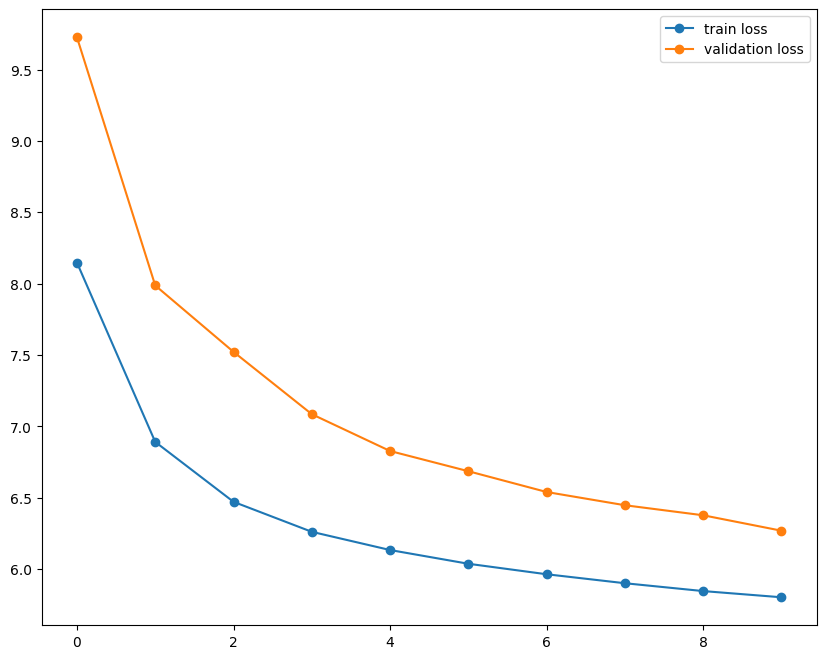

In [112]:
plt.figure(figsize=(10,8))
plt.plot(range(EPOCHS2), history2.history["loss"], marker="o", label="train loss")
plt.plot(range(EPOCHS2), history2.history["val_loss"], marker="o", label="validation loss")
plt.legend();